In [377]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

###Re-centering & re-normalization

In [405]:
# Re-center and re-normalize the training and testing set

def normalize(train,test):
    rmax = train.max(axis=0)
    rmin = train.min(axis=0)
    train_normalized = (train - rmin)/(rmax-rmin)
    test_normalized = (test - rmin)/(rmax-rmin)
    return train_normalized, test_normalized

## 2.1.2  Analytic expressions

In [157]:
def compute_obj(X,y,w,h,C):
    n = X.shape[0]
    mask_1 = X.dot(w)*y > 1+h
    mask_2 = abs(1-X.dot(w)*y) <= h
    mask_3 = X.dot(w)*y < 1-h
    #print X[mask_2].shape[0]+X[mask_1].shape[0]+X[mask_3].shape[0]
    #print X[mask_3].shape
    loss = w.dot(w) + C*(X[mask_2].dot(w)-(1+h)*y[mask_2]).dot(X[mask_2].dot(w)-(1+h)*y[mask_2])/(4*n*h) + C/n*(X[mask_3].shape[0]) - C*(X[mask_3].dot(w)).dot(y[mask_3])/n
    return loss

In [173]:
def compute_grad(X,y,w,h,C):
    n = X.shape[0]
    zero = np.zeros(w.shape[0])
    mask_1 = X.dot(w)*y > 1+h
    mask_2 = abs(1-X.dot(w)*y) <= h
    mask_3 = X.dot(w)*y < 1-h   
    #print C*X[mask_3].T.dot(y[mask_3])/n
    #print C*X[mask_2].dot((X[mask_2].dot(w)-(1+h)*y[mask_2]))/(2*n*h)
    grad = 2*w + C*np.dot(X[mask_2].T,X[mask_2].dot(w)-(1+h)*y[mask_2])/(2*n*h) - C*X[mask_3].T.dot(y[mask_3])/n
    return grad

In [546]:
# Gradient Checker

def grad_checker(X,y,w,h,C,eps=0.01,tolerance=1e-4):
    true_gradient = compute_grad(X,y,w,h,C)
    num_features = w.shape[0]
    approx_grad = np.zeros(num_features)
    for d in xrange(num_features):
        e = np.array([1 if i==d else 0 for i in xrange(num_features)])
        loss_plus = compute_obj(X,y,w+eps*e,h,C)
        loss_minus = compute_obj(X,y,w-eps*e,h,C)
        approx_grad[d] = (loss_plus+loss_minus)/(2*eps)
    
    Euclidean_dist = np.sqrt((true_gradient-approx_grad).T.dot(true_gradient-approx_grad))
    if Euclidean_dist<=tolerance:
        return True
    return False

In [473]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 500, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((-1*np.ones(n), np.ones(n)))
    return X, y

In [505]:
X,y = dataset_fixed_cov()

#X_design = np.hstack((X,y.reshape(X.shape[0],1)))
#random.shuffle(X_n)
#X_train,X_test,y_train,y_test = X_design[:800,:-1],X_design[800:,:-1],X_design[:800,-1],X_design[800:200,-1]
#train_idx = random.sample(xrange(X.shape[0]),800)
#test_idx = [i for i in xrange(X.shape[0]) if i not in train_idx]
#X_train = X_n[train_idx]
#X_test = X_n[test_idx]

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train_normalized,X_test_normalized = normalize(X_train,X_test)
X_train_normalized = np.hstack((X_train_normalized,np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)))
X_test_normalized = np.hstack((X_test_normalized,np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)))

In [475]:
w_init = np.zeros(X.shape[1])
compute_obj(X,y,w_init,0.05,0.5)

0.5

In [476]:
compute_grad(X,y,w_init,0.05,0.5)

array([-0.25632644, -0.24673575])

In [527]:
# Gradient Descent

w_init = np.zeros(X_train_normalized.shape[1])

def my_gradient_descent(X,y,w,epsilon,ita,h=0.05,C=1.0,max_iter=1000):
    grad = compute_grad(X,y,w,h,C)
    obj = compute_obj(X,y,w,h,C)
    #misclassification = []
    w_update = w - ita*(grad/np.sqrt(grad.dot(grad)))
    obj_update = compute_obj(X,y,w_update,h,C)
    grad_update = compute_grad(X,y,w_update,h,C)
    diff = abs(obj_update - obj)
    #misclassification.append(sum((y_train*X_train_normalized.dot(w_update)<0))/len(X_train_normalized))
    obj_list = [obj,obj_update]
    w_list = [w,w_update]
    while (max_iter>1) and (diff >= epsilon):
        obj = obj_update
        w_update = w_update - ita*(grad_update/np.sqrt(grad_update.dot(grad_update)))
        obj_update = compute_obj(X,y,w_update,h,C)
        grad_update = compute_grad(X,y,w_update,h,C)
        diff = abs(obj_update - obj)
        obj_list.append(obj_update)
        w_list.append(w_update)
        
        max_iter -= 1
    return w_list[-1],obj_update,obj_list,w_list

In [528]:
# Implement Linear SVM with huberized hinge loss using gradient descent algorithm

def my_svm(X,y,w,epsilon,ita,h=0.05,C=1.0,max_iter=1000):
    w_update,obj_update,obj_list,w_list = my_gradient_descent(X,y,w,epsilon,ita,h=0.05,C=1.0,max_iter=1000)
    return w_update,obj_update,obj_list,w_list

In [529]:
w_update,obj_update,obj_list,w_list = my_svm(X_train_normalized,y_train,w_init,epsilon=1e-5,ita=0.01*1.1**3,h=0.05,C=1.0,max_iter=1000)

In [530]:
print obj_list[-1],obj_list[1]

0.989389701562 0.997433619995


In [531]:
#ita_list = [0.01,0.1*1.1,0.1*1.1**3,0.1*1.1**5,1]
ita_list = [0.1*1.1,0.1*1.1**2,0.1*1.1**3,0.1*1.1**4,0.1*1.1**5]

In [532]:
ita_list

[0.11000000000000001,
 0.12100000000000002,
 0.13310000000000005,
 0.14641000000000004,
 0.16105100000000006]

In [533]:
X_train_normalized

array([[ 0.64749539,  0.67124566,  1.        ],
       [ 0.42204924,  0.26197748,  1.        ],
       [ 0.45668086,  0.6615314 ,  1.        ],
       ..., 
       [ 0.47160955,  0.57562792,  1.        ],
       [ 0.68157699,  0.60670797,  1.        ],
       [ 0.82418253,  0.88329045,  1.        ]])

et the separating hyperplane w = np.dot(clf.coef_[0], clf.support_) a = -w[0]/w[1] xx = np.linspace(-5, 5) yy = a*xx + (clf.rho_[0])/w[1] # plot the paralels to the separating hyperplane that pass through the # support vectors b = clf.support_[0] yy_down = a*xx + (b[1] - a*b[0]) b = clf.support_[-1] yy_up = a*xx + (b[1] - a*b[0]) # plot the line, the points, and the nearest vectors to the plane pl.set_cmap(pl.cm.Paired) pl.plot(xx, yy, 'k-') pl.plot(xx, yy_down, 'k--') pl.plot(xx, yy_up, 'k--') pl.scatter(X[:,0], X[:,1], c=Y) pl.scatter(clf.support_[:,0], clf.support_[:,1], marker='+') pl.axis('tight') pl.show() [/cc] And the result is

In [534]:
w_update

array([ 0.05320156,  0.09150132,  0.01162299])

In [535]:
a = - w_update[0] / w_update[1]

In [536]:
y_train

array([ 1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,
       -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,
        1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
        1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1

In [537]:
# misclassificaiton error

1.0*sum((y_train*X_train_normalized.dot(w_update)<0))/len(X_train_normalized)

0.48875

In [538]:
from sklearn.svm import LinearSVC

lin_clf = LinearSVC()
lin_clf.fit(X_train_normalized,y_train)  
lin_clf.score(X_test_normalized,y_test)

0.95999999999999996

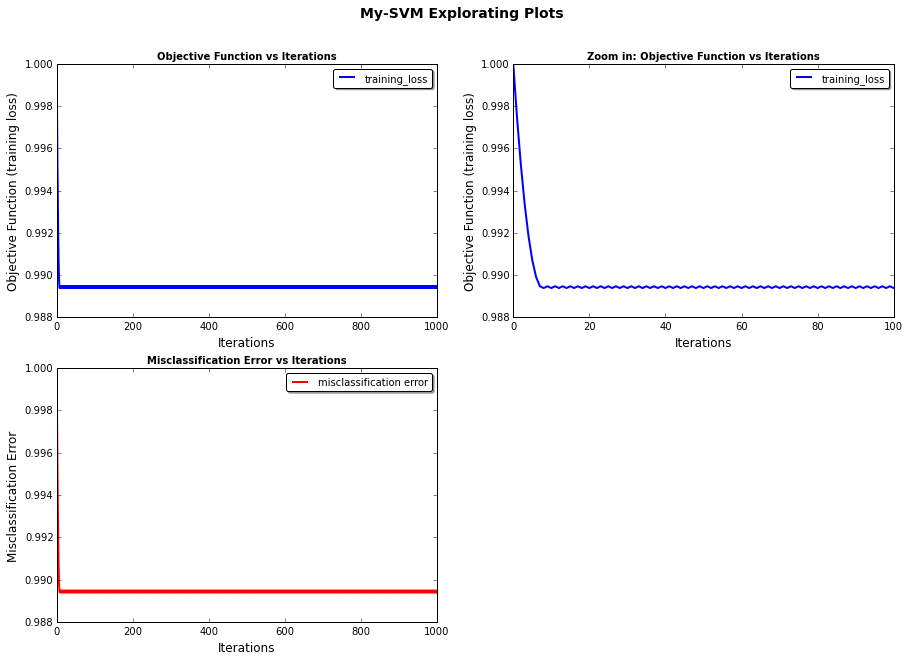

In [539]:
# My-SVM

fig = plt.figure(facecolor='white',figsize=(15,10))
fig.suptitle('My-SVM Explorating Plots',fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9)

ax0 = fig.add_subplot(221)
ax0.set_title('Objective Function vs Iterations',fontsize=10,fontweight='bold')
ax0.plot(xrange(len(obj_list)),obj_list,label='training_loss',lw=2,color='b')
ax0.set_xlabel('Iterations',fontsize=12)
ax0.set_ylabel('Objective Function (training loss)',fontsize=12)
ax0.legend(prop={'size':10},loc='upper right', fancybox=True, shadow=True, ncol=3)

ax1 = fig.add_subplot(222)
ax1.set_title('Zoom in: Objective Function vs Iterations',fontsize=10,fontweight='bold')
ax1.plot(xrange(len(obj_list)),obj_list,label='training_loss',lw=2,color='b')
ax1.set_xlabel('Iterations',fontsize=12)
ax1.set_xlim(0,100)
ax1.set_ylabel('Objective Function (training loss)',fontsize=12)
ax1.legend(prop={'size':10},loc='upper right', fancybox=True, shadow=True, ncol=3)

ax2 = fig.add_subplot(223)
ax2.set_title('Misclassification Error vs Iterations',fontsize=10,fontweight='bold')
ax2.plot(xrange(len(obj_list)),obj_list,label='misclassification error',lw=2,color='r')
ax2.set_xlabel('Iterations',fontsize=12)
ax2.set_ylabel('Misclassification Error',fontsize=12)
ax2.legend(prop={'size':10},loc='upper right', fancybox=True, shadow=True, ncol=3)

In [540]:
sum((y_train*X_train_normalized.dot(w_update)<0))/1000.0

0.39100000000000001